## MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
type(y)

numpy.ndarray

In [5]:

y.shape

(70000,)

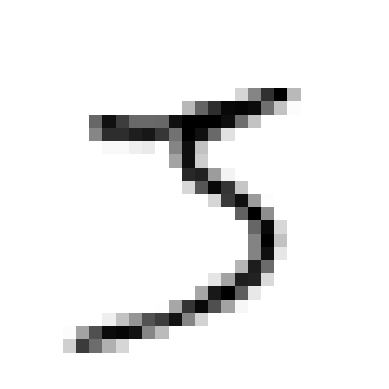

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

some_digit = X[np.random.randint(0,69999)]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y = y.astype(np.uint8)

Training set is already shuffled

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classification

Classifier for a single digit

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=23)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=23)

In [11]:
sgd_clf.predict([some_digit])


array([False])

## Manually implementing Cross-Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9682
0.96625
0.94645


## Using cross_val_score

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96755, 0.96715, 0.96655])

Estimating accuracy with classifier that nevers predicts 5

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

[[tru_neg, false_pos],
[true_pos, false_neg]]

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53895,   684],
       [ 1291,  4130]], dtype=int64)

precision = TP/(TP+FP), recall(sensitivity/true positive rate) = TP/(TP+FN)

In [18]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.857914416285833
0.7618520568160856


F1 score = 2/((1/precision) + (1/recall))

In [19]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.8070346849047386


In [20]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([-350.45556795])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
precisions[:-1]

array([0.09047818, 0.090463  , 0.09046451, ..., 1.        , 1.        ,
       1.        ])

In [24]:
recalls.shape

(59916,)

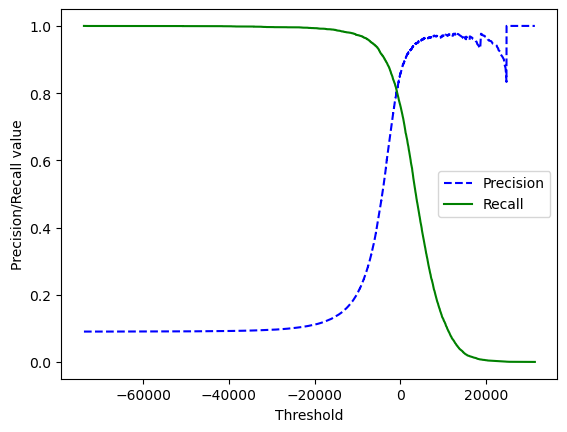

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall value')
    plt.legend(loc='best')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## ROC Curve

Plots the true positive rate versus the false positive rate

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

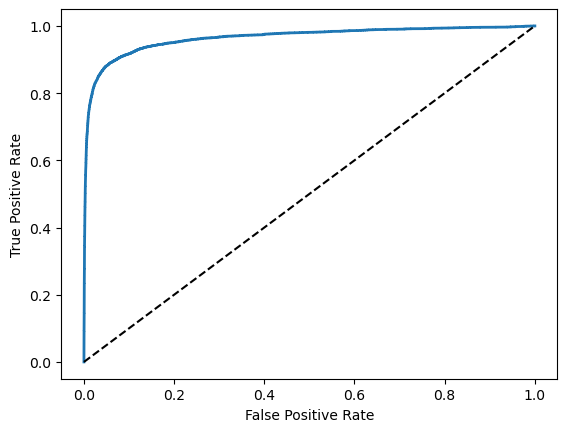

In [28]:
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9644818095605753

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=32)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [31]:
y_scores_forest = y_probas_forest[:,1] #score = probability of postive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

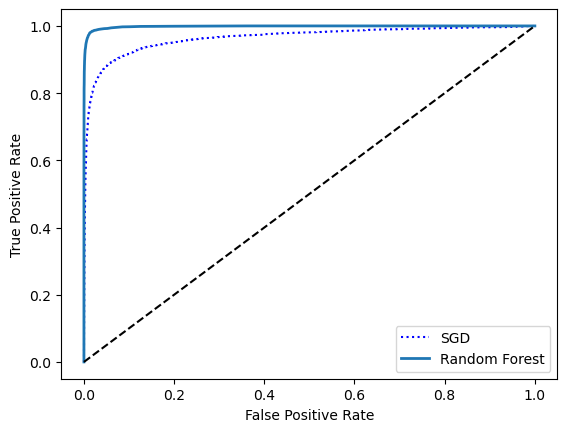

In [32]:
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983814664059696

## Multiclass Classification

#### One-vs-one strategy

In [34]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([3], dtype=uint8)

In [35]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [36]:
some_digit_scores

array([[ 1.73001213,  3.76406289,  2.72665245,  9.30902075,  0.6961332 ,
         8.30178863, -0.30103535,  7.28274292,  4.8180515 ,  6.26935375]])

In [37]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### One-versus-all strategy

In [38]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([3], dtype=uint8)

In [39]:
len(ovr_clf.estimators_)

10

In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87945, 0.8626 , 0.8867 ])

#### Scaling the inputs to imporve performance

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.89545, 0.8955 , 0.9031 ])

## Error Analysis

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

#### Confusion matrix

In [44]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5570,    0,   22,    5,    8,   48,   36,    5,  228,    1],
       [   0, 6404,   39,   23,    4,   44,    4,    8,  205,   11],
       [  28,   27, 5249,   89,   70,   27,   65,   38,  357,    8],
       [  23,   19,  121, 5204,    1,  215,   25,   41,  411,   71],
       [  12,   14,   47,    9, 5186,   12,   38,   26,  333,  165],
       [  25,   15,   32,  171,   51, 4467,   80,   15,  505,   60],
       [  30,   15,   45,    2,   41,   97, 5558,    3,  126,    1],
       [  19,   10,   52,   26,   49,   14,    3, 5702,  185,  205],
       [  17,   64,   49,   85,    3,  124,   27,   10, 5430,   42],
       [  21,   18,   29,   61,  121,   36,    1,  178,  373, 5111]],
      dtype=int64)

#

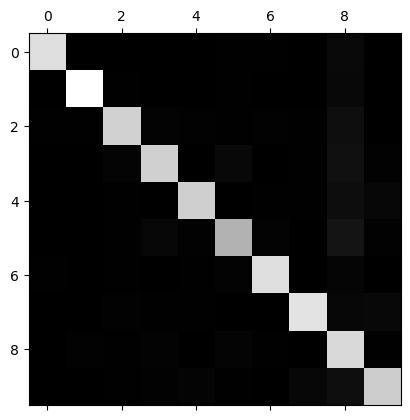

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#### Errors only

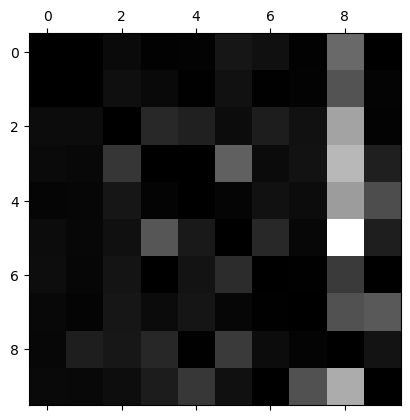

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

## Multilabel Classification

In [48]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [49]:
knn_clf.predict([some_digit])

c:\Users\hollo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

#### Compute average F1 score across all labels

In [52]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

c:\Users\hollo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\hollo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.976410265560605

## Multioutput Classification

System that removes noise from image 

In [56]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [59]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1]])

c:\Users\hollo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
